<a href="https://colab.research.google.com/github/tessytom/content-creation/blob/main/Kopie_von_Vicious_Visionaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Install dependencies
!pip install torch_intermediate_layer_getter --quiet
!pip install Pillow --quiet

In [ ]:
# Imports
import random
import time

import numpy as np
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter
from shutil import copyfile, rmtree
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
# For getting output of intermediate layers in Pytorch
from torch_intermediate_layer_getter import IntermediateLayerGetter as LayerGetter
# For interactive visualization
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import transforms
import torchvision.models as models


%load_ext tensorboard

In [ ]:
# @title Helpers functions
def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
SEED = 42
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 42 has been set.


Modification of the network taken from : https://medium.com/@buiminhhien2k/solving-cifar10-dataset-with-vgg16-pre-trained-architect-using-pytorch-validation-accuracy-over-3f9596942861

In [ ]:
# @title Load the model 
model = models.vgg19(pretrained = False, progress=True)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer,10)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# @title Load a much simpler model (and overwrite)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 18, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(18, 36, 5)
        self.fc1 = nn.Linear(36 * 5 * 5, 120)
        self.drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.fc3(x)
        # x = F.softmax(x)
        return x

model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 18, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(18, 36, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=900, out_features=120, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# @title Load data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = F"/content/drive/My Drive/CIFAR-10-C/" 
#filename1 = 'motion_blur.npy'
#filename_labels = 'labels.npy'
#motion_blur_data = np.load(path+filename1)
#labels = np.load(path+filename_labels)
#motion_blur_data.shape
#motion_blur_data.shape

In [ ]:
class CorruptedDataset(torch.utils.data.Dataset):
    def __init__(self, file_name, severity_level, transform = None):
        self.imgs_path = F"/content/drive/My Drive/CIFAR-10-C/" 
        file_name = path+file_name
        data = np.load(file_name)
        labels = np.load(path + 'labels.npy')

        if severity_level == 'high':
            self.data = data[-10000:]
            self.labels = labels[-10000:]
        elif severity_level == 'low':
            self.data = data[:10000]
            self.labels = labels[:10000]
        print(self.data.shape)
        self.class_map = {"airplane" : 0, "automobile" : 1, "bird" : 2, "cat" : 3,
                          "deer" : 4, "dog" : 5, "frog" : 6, "horse" : 7, "ship" : 8,
                          "truck" : 9}
        self.img_dim = (32,32)
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, class_id = self.data[idx], self.labels[idx]
        class_id = torch.tensor([class_id], dtype=torch.long)
        if self.transform:
            img_tensor = self.transform(img)
        return img_tensor, class_id.squeeze()

In [ ]:
corruption_type_list = ['motion_blur.npy', 'defocus_blur.npy', 'gaussian_noise.npy', 'shot_noise.npy']
severity_level = 'low'#['high', 'low']
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

dataset1 = CorruptedDataset(corruption_type_list[0], severity_level, transform=transform)
dataset2 = CorruptedDataset(corruption_type_list[1], severity_level, transform=transform)

dataset_concat = torch.utils.data.ConcatDataset([dataset1, dataset2])

batch_size = 100
trainloader = torch.utils.data.DataLoader(dataset_concat, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

(10000, 32, 32, 3)
(10000, 32, 32, 3)


**TO DO: Load other corruption types and concatenate datasets**

torch.Size([100, 3, 32, 32])


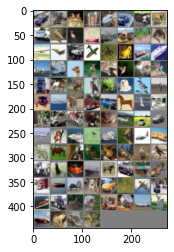

  car  bird  frog   cat  ship   car   dog  deer truck  bird   cat  ship  ship  bird  frog   cat plane plane truck plane  bird  frog  ship  ship plane truck  bird  deer   cat  bird horse horse truck horse  deer  bird  frog   dog  bird  deer   cat  ship   cat truck   car horse  bird   cat   cat   car   car  bird  frog plane   car   car plane   dog  ship  bird  ship   dog plane truck  frog horse   cat   cat  frog   cat  frog  bird truck   dog   car  ship horse   car truck  frog truck  ship plane   dog   car  deer plane truck  ship truck  deer   dog   car   cat plane  deer  ship  frog  frog   cat


In [ ]:
# @title Take a look at the data 

# functions to show an image
def imshow(img):
    img = img/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


# Train the model

In [ ]:
# take a look at the dimensionality 
print(trainloader.dataset)
# print(testloader.dataset)

In [ ]:
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.to(DEVICE)
    criterion = criterion.to(DEVICE)

Open issue: Not sure if we should implement some form of k-fold crossvalidation or not?
https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/

In [ ]:
# function to compute accuracy (could be probably implemented in a better way)
def accuracy(outputs, labels):
  correct_pred=0
  total_pred=0
  predictions = torch.argmax(outputs,dim=1)
  for label, prediction in zip(labels, predictions):
    if label == prediction:
      correct_pred += 1
    total_pred += 1
  accuracy = correct_pred/total_pred
  return accuracy


In [ ]:
# function to plot the trianing loss and accuracy and the test accuracy
def plot_train_loss_acc(losses, accuracies_train, accuracies_test, fext):
    plt.figure()
    fig, axs = plt.subplots(1,2)
    axs[0].plot( losses, label='Training Loss' )
    axs[0].set_xlabel('epochs') ; axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot( accuracies_train, label='Training Accuracy' )
    axs[1].plot( accuracies_test, label='Test Accuracy' )
    axs[1].set_xlabel('epochs') ; axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim([0.0,1.05])
    axs[1].legend()
    fig.tight_layout(pad=3.0)
    plt.savefig(fext + 'losses_accuracies.png', bbox_inches='tight')

In [ ]:
# training loop
training_loss = []
training_accuracy = []
test_accuracy = []
wait = 0 
early_stop_param = 10 

for epoch in range(50):  # loop over the dataset multiple times

    model.train()
    running_loss = 0.0
    acc = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 1000 == 999:    # print every 10 mini-batch
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss))
        #     running_loss = 0.0
    

    # test_acc = []#0.0
    # for i, data in enumerate(testloader):
    #   # get the inputs; data is a list of [inputs, labels]
    #   inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

    #   model.eval()
    #   with torch.no_grad():
    #     # forward + backward + optimize
    #     outputs = model(inputs)
    #     test_acc.append(accuracy(outputs, labels))
    # test_accuracy.append(np.array(test_acc).mean())

    # if np.array(test_acc).mean() < max(test_accuracy):
    #   wait += 1   
    # else:
    #   wait = 0  

    # if wait == early_stop_param:
    #    print('Early stepped at [%d] epoch. Loss: %.3f. Training accuracy: %.3f . Test accuracy: %.3f' %
    #        (epoch + 1, running_loss, acc, np.array(test_acc).mean()))
    #    training_loss.append(running_loss)
    #    training_accuracy.append(acc) 
    #    break 

    print('[%d] epoch. Loss: %.3f. Training accuracy: %.3f '%
           (epoch + 1, running_loss, acc))
    # print('[%d] epoch. Loss: %.3f. Training accuracy: %.3f . Test accuracy: %.3f' %
    #        (epoch + 1, running_loss, acc, np.array(test_acc).mean()))
    training_loss.append(running_loss)
    training_accuracy.append(acc)

print('Finished Training')

[1] epoch. Loss: 223.826. Training accuracy: 0.220 
[2] epoch. Loss: 204.292. Training accuracy: 0.310 
[3] epoch. Loss: 190.921. Training accuracy: 0.310 
[4] epoch. Loss: 182.726. Training accuracy: 0.410 
[5] epoch. Loss: 175.928. Training accuracy: 0.280 
[6] epoch. Loss: 169.449. Training accuracy: 0.390 
[7] epoch. Loss: 166.834. Training accuracy: 0.380 
[8] epoch. Loss: 163.432. Training accuracy: 0.360 
[9] epoch. Loss: 160.188. Training accuracy: 0.440 


KeyboardInterrupt: ignored

*Training loss, training accuracy and test accuracy*

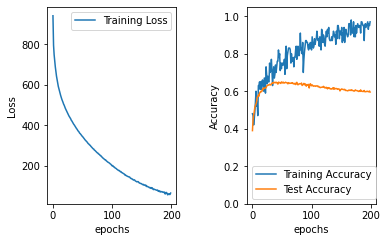



# Save the final model configuration

Mount my google Drive to save results there

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Save the model

In [ ]:
#save the trained model
model_save_name = 'trainedSimpleNet.pt'
path = F"/content/drive/My Drive/{model_save_name}" 
#torch.save(model.state_dict(), path)

# load the model
# model.load_state_dict(torch.load(path))

In [ ]:
DEVICE